In [1]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

import numpy as np
import json
import re
import string

import tensorflow as tf
from tensorflow.keras import (models, layers, callbacks, losses)

2024-03-25 11:10:26.636140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 11:10:26.636200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 11:10:26.636839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 11:10:26.641318: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 11:10:27.221033: W tensorflow/compiler/tf2

In [2]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS=128
VALIDATION_SPLIT = 0.2
SEED = 42
BATCH_SIZE = 32
EPOCHS = 100

In [3]:
with open ("./epirecipes/full_format_recipes.json") as json_data:
    recipe_data = json.load(json_data)
    
filtered_data = [
    "Recipe for " + x["title"] + " | " + " ".join(x["directions"])
    for x in recipe_data
    if "title" in x
    and x["title"] is not None
    and "directions" in x
    and x["directions"] is not None
]

n_recipe = len(filtered_data)
print(f"{n_recipe} recipes loaded")

example = filtered_data[18]
print(example)


20111 recipes loaded
Recipe for Mozzarella-Topped Peppers with Tomatoes and Garlic  | Preheat oven to 375°F. Oil baking sheet. Arrange peppers, cut side up, on sheet. Mix tomatoes and garlic in medium bowl. Season with salt and pepper. Fill pepper cavities with tomato mixture. Drizzle 1 teaspoon oil over each. Place 2 anchovy fillets atop each. Bake until peppers are tender, about 50 minutes. Arrange cheese atop peppers. Bake until cheese melts, about 3 minutes. Transfer peppers to platter. Sprinkle with basil and serve.


In [4]:
def pad_punctuations(s):
    s = re.sub(f"([{string.punctuation}])", r"\1", s)
    s = re.sub(" +", " ", s)
    return s

text_data = [pad_punctuations(x) for x in filtered_data]
print(text_data[:10])

example_data = text_data[19]
print(" ")
print(example_data)

text_ds = (tf.data.Dataset.from_tensor_slices(text_data).batch(BATCH_SIZE).shuffle(1000))

vectorise_layer = layers.TextVectorization(standardize="lower", max_tokens=VOCAB_SIZE, output_mode="int", output_sequence_length=MAX_LEN + 1,)
vectorise_layer.adapt(text_ds)
vocab = vectorise_layer.get_vocabulary()
print(" ")
for i,word in enumerate(vocab[:10]):
    print(f"Vocab\n{i} : {word}")

example_tokenized = vectorise_layer(example_data)
print()
print("Tokenized : ",example_tokenized.numpy())

['Recipe for Lentil, Apple, and Turkey Wrap | 1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool. 2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper. 3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.', 'Recipe for Boudin Blanc Terrine with Red Onion Confit | Combine first 9 ingredients in heavy medium sau

2024-03-25 11:10:30.500290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 11:10:30.520825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 11:10:30.520875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 11:10:30.523435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 11:10:30.523497: I external/local_xla/xla/stream_executor

 
Vocab
0 : 
Vocab
1 : [UNK]
Vocab
2 : and
Vocab
3 : to
Vocab
4 : in
Vocab
5 : the
Vocab
6 : with
Vocab
7 : a
Vocab
8 : until
Vocab
9 : of


2024-03-25 11:10:32.110237: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory



Tokenized :  [  17   10 2896 2105    2 1979  366  185    6 2075  501    2  902 1778
   18  423  331   48  121    4  356    8  188    6 1542 1111  349   11
  350  199   30  224  243   43    3  151    6   23    2   52  227  367
  127   44  100   14  159   94   41    2  347   37  612    4   22   53
    9  204  285   39    8   72  114   63    3   48   12   25  612    3
 1214   56    9  172   39    3  230  142  612    2  312  464  227  367
  127   44  100  122  187   94  264    4  171 2276   30 3187    2  347
   45  156    4   22  258   11  193   39    3   41  156  147   14 1599
   69    6  209   65    3  110    2   37    8  156   62  114   73    3
  102  109 1585   20 1793    9 1079 1361   49   74   48   12   45    4
   35   50   11   95   42 4415   88    3  276   43    3  151    6   23
    2   52   21  224   36    4   46   53   15  140   70   11 1778    2
  602    8 1778   62  621    2  779 1295 5673   47  477  387    3 2672
  395   75  274  342   25 1778    3  171  471    3  369  227  3

In [5]:
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorise_layer(text)
    x = tokenized_sentences[:,:-1]
    y = tokenized_sentences[:,1:]
    return x, y

train_ds = text_ds.map(prepare_inputs)
print(train_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), TensorSpec(shape=(None, 200), dtype=tf.int64, name=None))>


In [6]:
inputs = layers.Input(shape=(None, ), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, None, 128)         117248    
                                                                 
 dense (Dense)               (None, None, 10000)       1290000   
                                                                 
Total params: 2407248 (9.18 MB)
Trainable params: 2407248 (9.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
if False:
    models.load_model("./models/lstm", compile=False)

loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {word : index for index, word in enumerate(index_to_word)}
        
    def sample_from(self, probs, temperature):
        probs = probs ** (1/temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs
    
    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [self.word_to_index.get(x,1) for x in start_prompt.split()]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token !=0:
            x = np.array([start_tokens])
            y = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append({"prompt":start_prompt, "word_probs":probs})
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\nGenerated text:\n{start_prompt}\n")
        return info
    
    def on_epoch_end(self, epoch, logs=None):
        self.generate("recipe for", max_tokens=100, temperature=1.0)

In [8]:
model_checkpoint_callback = callbacks.ModelCheckpoint(filepath="./checkpoint/checkpoint.ckpt",
                                                     save_weights_only=True,
                                                     save_freq="epoch",
                                                     verbose=0)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")
text_gen = TextGenerator(vocab)

lstm.fit(train_ds, epochs=EPOCHS, callbacks=[model_checkpoint_callback, tensorboard_callback, text_gen])

Epoch 1/100


2024-03-25 11:10:34.060929: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-25 11:10:34.125574: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f45e488c980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 11:10:34.125628: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-03-25 11:10:34.129956: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711345234.186923    8200 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


629/629 [==============================] - ETA: 0s - loss: 4.5046
Generated text:
recipe for sauté | combine garlic, (can pot and heavy a remaining simmers 

629/629 [==============================] - 62s 96ms/step - loss: 4.5046
Epoch 2/100
629/629 [==============================] - ETA: 0s - loss: 3.4440
Generated text:
recipe for [UNK] flakes, shrimp | remove bottom into small an bare 4 juice in heavy 2 line a colander with cool in a 12-inch colander. cook until not yolks, flour and add 2 tablespoons water and peel) until batch, syrup and cook until fragrant, about sauce whisking occasionally, over bring to sugar and 5 minutes. drain. chill, aside. turn sandwiches at sheet and beer, covered [UNK] to small heat. transfer 2 hours, leaving a processor on medium heat and oil, cream mixture to medium-low skillet from boiling [UNK] for oil; add child: vegetables and let over minute. transfer with

629/629 [==============================] - 53s 84ms/step - loss: 3.4440
Epoch 3/100
629/629 

In [9]:
def print_probs(info, top_k=5):
    for i in info:
        print(f"\nPROMPT: {i['prompt']}")
        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]} : \t{np.round(100*p,2)}%")
        print("--------------\n")
        
info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.1)
print(" ")
print("Generated Text for Temperature 0.1 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.2)
print(" ")
print("Generated Text for Temperature 0.2 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.3)
print(" ")
print("Generated Text for Temperature 0.3 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.4)
print(" ")
print("Generated Text for Temperature 0.4 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.5)
print(" ")
print("Generated Text for Temperature 0.5 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.6)
print(" ")
print("Generated Text for Temperature 0.6 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.7)
print(" ")
print("Generated Text for Temperature 0.7 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.8)
print(" ")
print("Generated Text for Temperature 0.8 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=0.9)
print(" ")
print("Generated Text for Temperature 0.9 : ")
print_probs(info, vocab)
print(" ")

info = text_gen.generate("recipe for true vanilla ice cream | chop 1 /", max_tokens=10, temperature=1.0)
print(" ")
print("Generated Text for Temperature 1.0 : ")
print_probs(info, vocab)
print(" ")


Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.1 : 
 

Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.2 : 
 

Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.3 : 
 

Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.4 : 
 

Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.5 : 
 

Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.6 : 
 

Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.7 : 
 

Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.8 : 
 

Generated text:
recipe for true vanilla ice cream | chop 1 /

 
Generated Text for Temperature 0.9 : 
 

Generated text:
recipe for true vanilla ice cream | ch

In [10]:
lstm.history.history.keys()

dict_keys(['loss'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


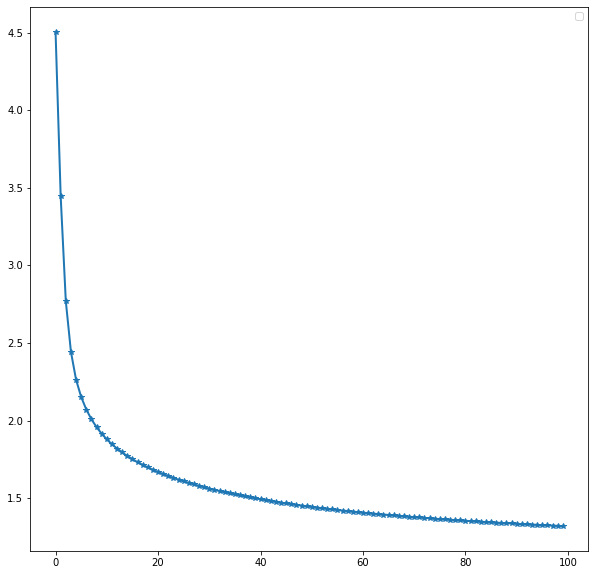

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(lstm.history.history["loss"], linewidth=2, marker='*')
plt.gca()
plt.legend()
plt.show()